Import needed stuff

In [4]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [5]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

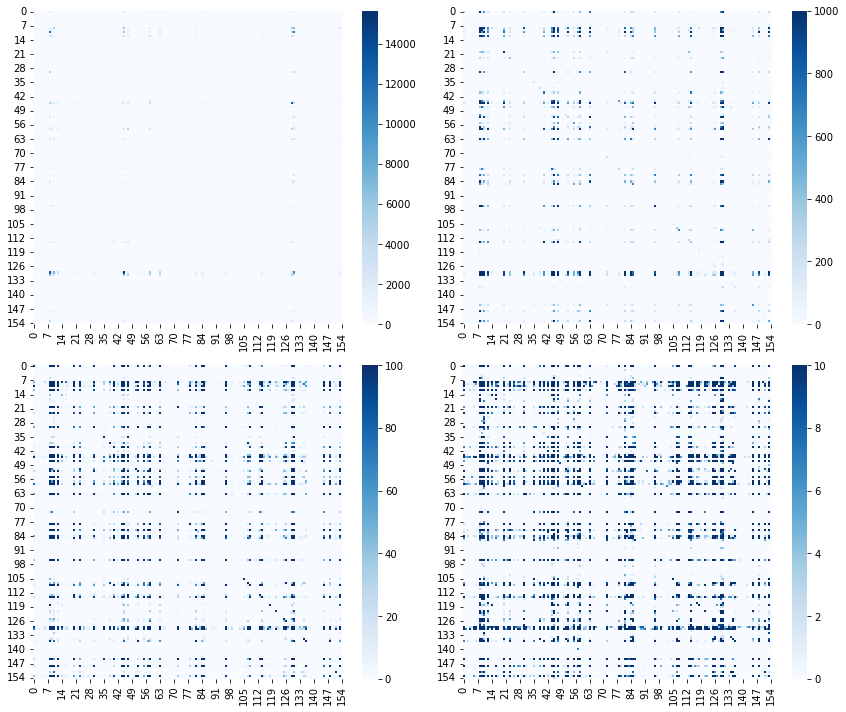

In [6]:
country_df = df[df[df.columns[10]]=='Learner']
country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

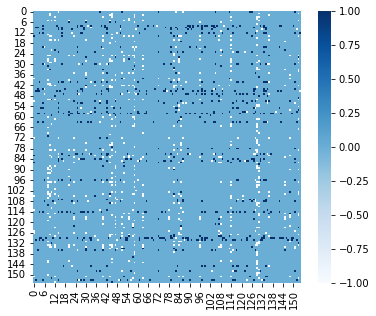

In [7]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [8]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 1


### Degree distribution

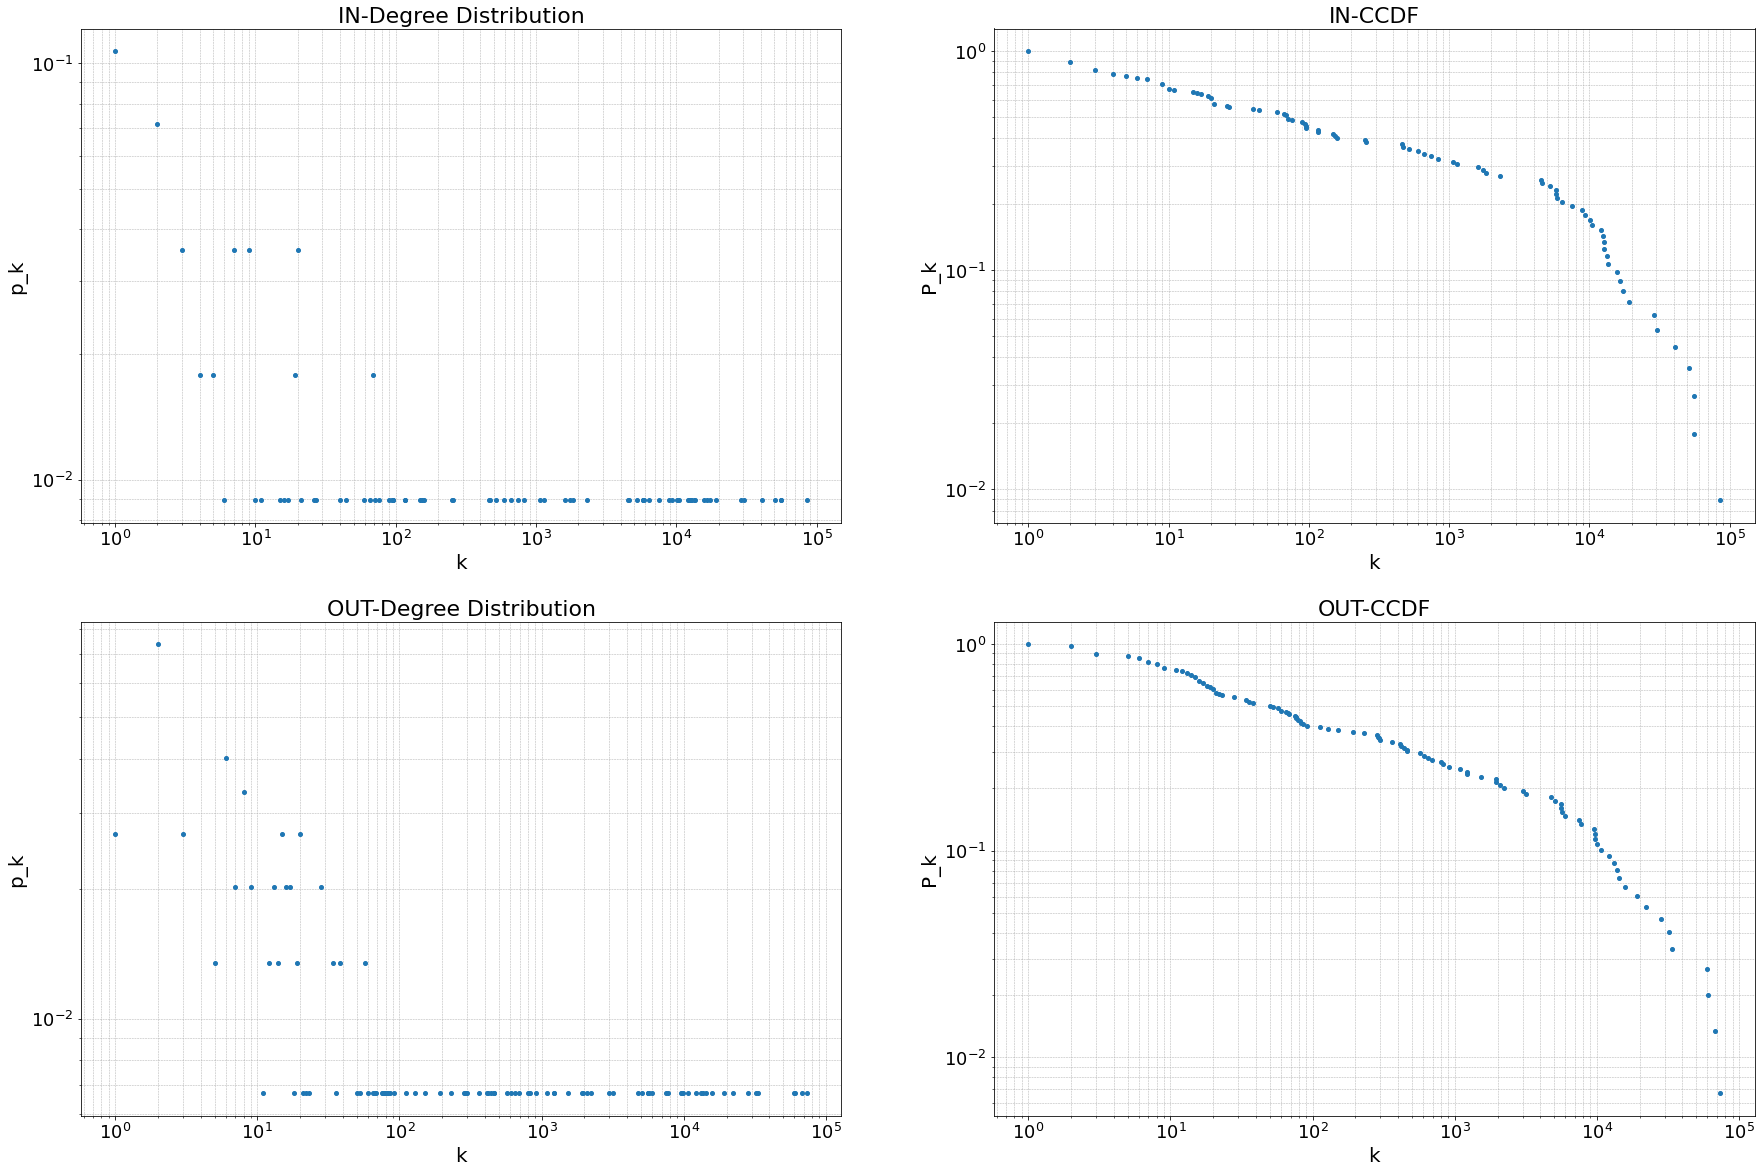

Top 10 for in degree


,Nodes,in degree
129,Spain,85255
10,UK,55556
130,Germany,55489
45,Italy,50912
8,France,40840
58,Poland,30154
12,Portugal,28984
63,Netherlands,19163
30,Ireland,17474
114,Czechia,16559


Top 10 for out degree


,Nodes,out degree
8,France,73481
130,Germany,67772
45,Italy,60222
129,Spain,59413
47,Turkey,33511
58,Poland,32388
10,UK,28448
63,Netherlands,22090
9,Romania,19294
12,Portugal,15750


In [9]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

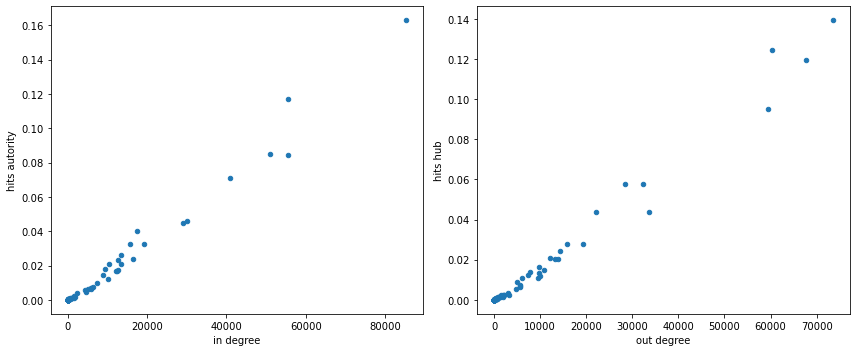

Top 10 for hits hub


,Nodes,hits hub
8,France,0.139283
45,Italy,0.124679
130,Germany,0.119749
129,Spain,0.094932
10,UK,0.057723
58,Poland,0.057705
63,Netherlands,0.043805
47,Turkey,0.043587
9,Romania,0.027973
12,Portugal,0.027626


Top 10 for hits autority


,Nodes,hits autority
129,Spain,0.162843
10,UK,0.117227
45,Italy,0.085113
130,Germany,0.084523
8,France,0.071154
58,Poland,0.046151
12,Portugal,0.044684
30,Ireland,0.040060
153,Belgium,0.032396
63,Netherlands,0.032326


In [10]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

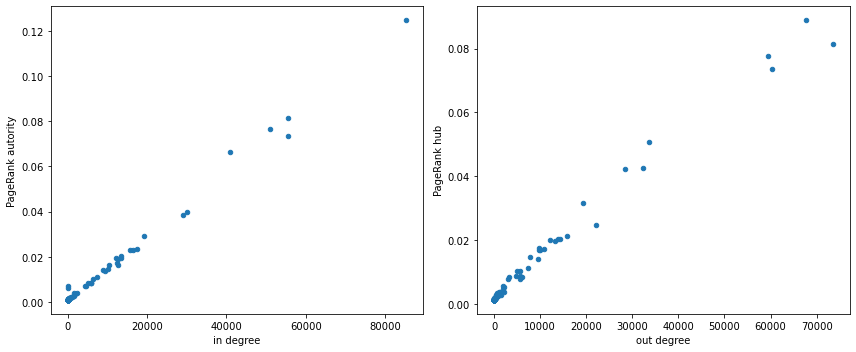

Top 10 for PageRank hub


,Nodes,PageRank hub
130,Germany,0.088870
8,France,0.081390
129,Spain,0.077764
45,Italy,0.073692
47,Turkey,0.050792
58,Poland,0.042699
10,UK,0.042150
9,Romania,0.031626
63,Netherlands,0.024640
12,Portugal,0.021385


Top 10 for PageRank autority


,Nodes,PageRank autority
129,Spain,0.124574
130,Germany,0.081602
45,Italy,0.076687
10,UK,0.073659
8,France,0.066544
58,Poland,0.040025
12,Portugal,0.038717
63,Netherlands,0.029240
30,Ireland,0.023405
114,Czechia,0.023160


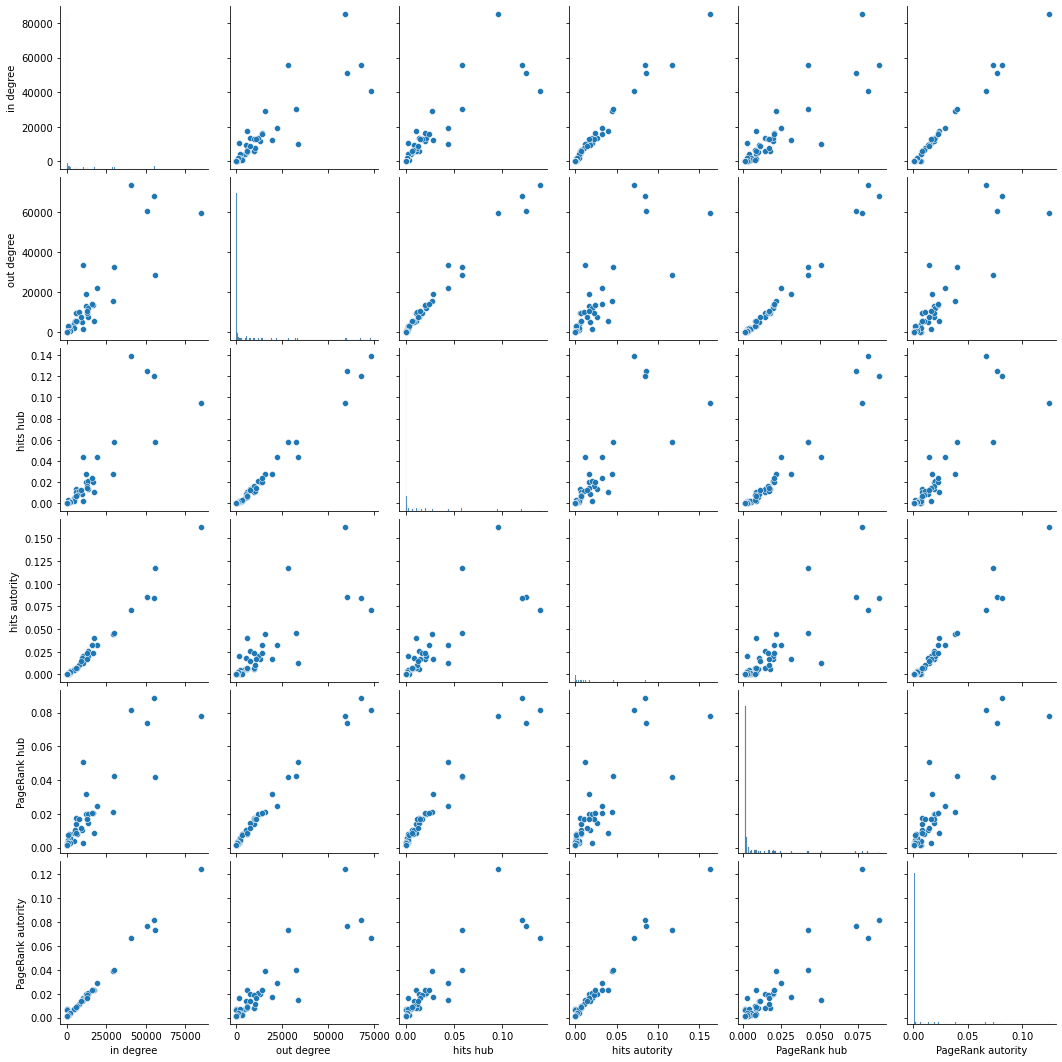

In [11]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')

sns.pairplot(scores)
plt.show()

In [12]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank autority')
scores.sort_index(inplace=True)

In [13]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank autority,PageRank autority position
129,Spain,85255,1,0.162843,1,0.124574,1
130,Germany,55489,3,0.084523,4,0.081602,2
45,Italy,50912,4,0.085113,3,0.076687,3
10,UK,55556,2,0.117227,2,0.073659,4
8,France,40840,5,0.071154,5,0.066544,5
58,Poland,30154,6,0.046151,6,0.040025,6
12,Portugal,28984,7,0.044684,7,0.038717,7
63,Netherlands,19163,8,0.032326,10,0.029240,8
30,Ireland,17474,9,0.040060,8,0.023405,9
114,Czechia,16559,10,0.023774,12,0.023160,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
130,Germany,67772,2,0.119749,3,0.088870,1
8,France,73481,1,0.139283,1,0.081390,2
129,Spain,59413,4,0.094932,4,0.077764,3
45,Italy,60222,3,0.124679,2,0.073692,4
47,Turkey,33511,5,0.043587,8,0.050792,5
58,Poland,32388,6,0.057705,6,0.042699,6
10,UK,28448,7,0.057723,5,0.042150,7
9,Romania,19294,9,0.027973,9,0.031626,8
63,Netherlands,22090,8,0.043805,7,0.024640,9
12,Portugal,15750,10,0.027626,10,0.021385,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

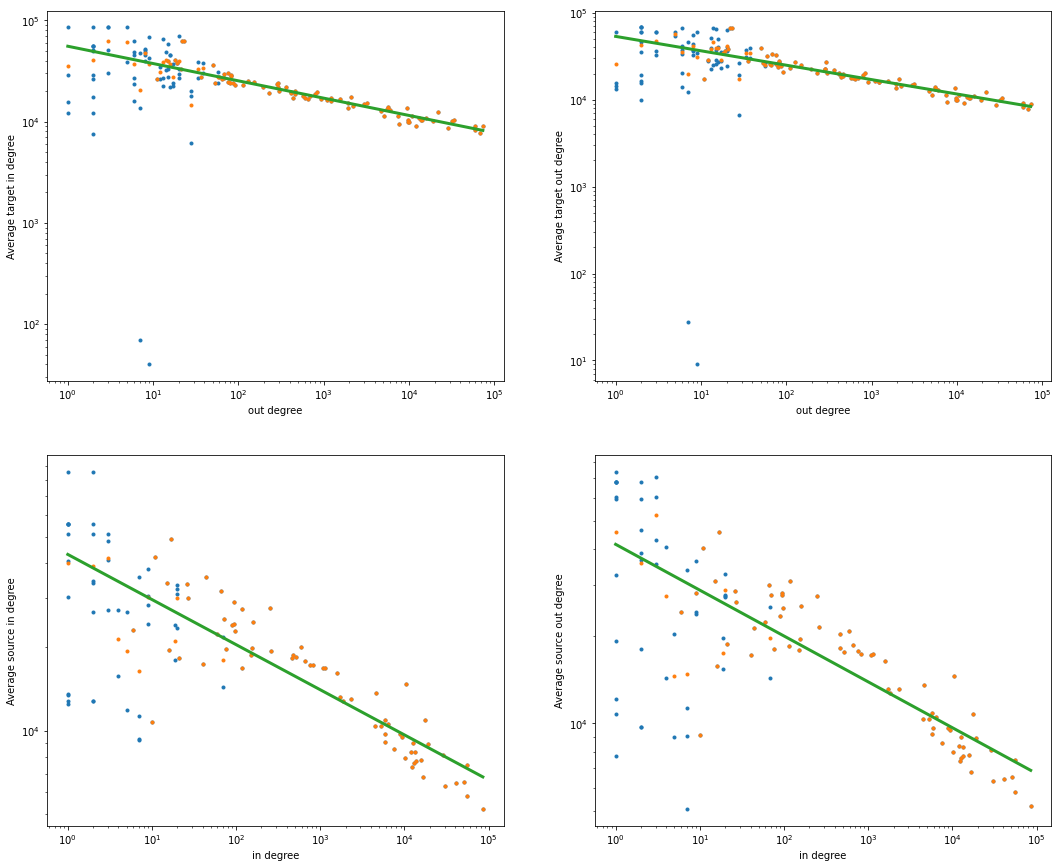

(-0.1709131474314809,
 -0.16566416781192514,
 -0.16258008251223896,
 -0.15802291954725187)

In [14]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

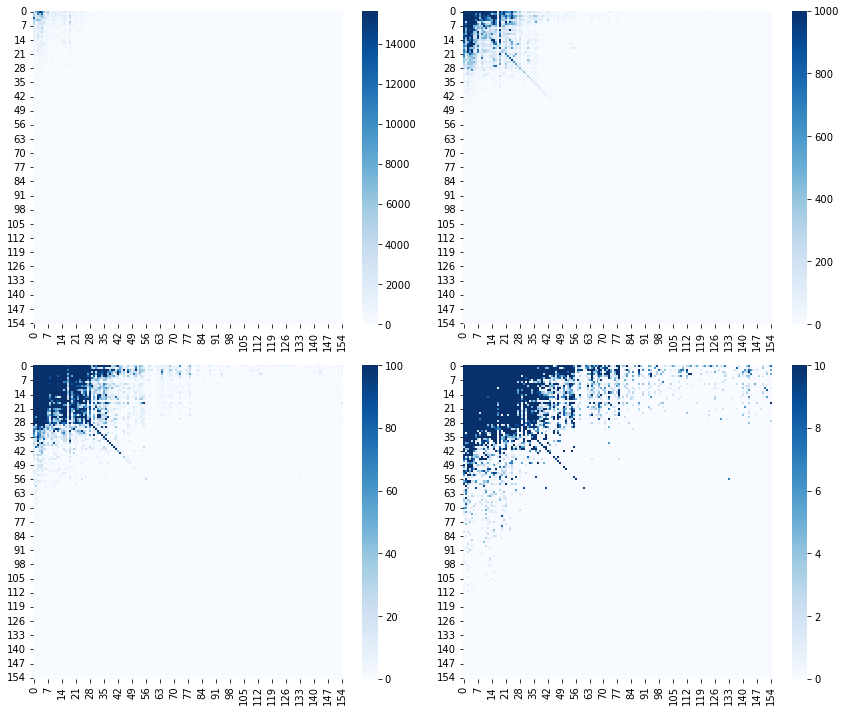

In [15]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

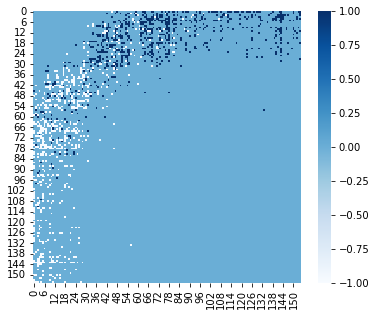

In [16]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [17]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
1,Cameroon,0
3,Syrian Arab Republic,0
6,Japan,0
7,Uruguay,0
8,France,0
...,...,...
146,Belize,0
147,Niger,0
149,"Bolivia, Plurinational State of",0
150,Côte d'Ivoire,0


,Nodes,Community
0,Malta,1
4,Libya,1
11,Fiji,1
12,Portugal,1
20,Bulgaria,1
23,Estonia,1
30,Ireland,1
35,Bosnia and Herzegovina,1
38,Armenia,1
40,Slovakia,1


,Nodes,Community
2,Uganda,2
5,South Africa,2
9,Romania,2
10,UK,2
17,Canada,2
18,Brunei Darussalam,2
19,Papua New Guinea,2
21,Kenya,2
22,"Korea, Republic of",2
27,Chile,2


,Nodes,Community
34,Nicaragua,3
49,French Polynesia,3
67,"Congo, The Democratic Republic of the",3
115,China,3
116,Rwanda,3
132,Aruba,3
153,Belgium,3


,Nodes,Community
16,Lebanon,4
36,Bangladesh,4
47,Turkey,4
59,Sint Maarten (Dutch part),4
80,Afghanistan,4
102,Montserrat,4


,Nodes,Community
14,Tunisia,5
57,Norway,5
83,Jordan,5
105,"Palestine, State of",5
140,Greenland,5


## Geographic Heat map 

<AxesSubplot:>

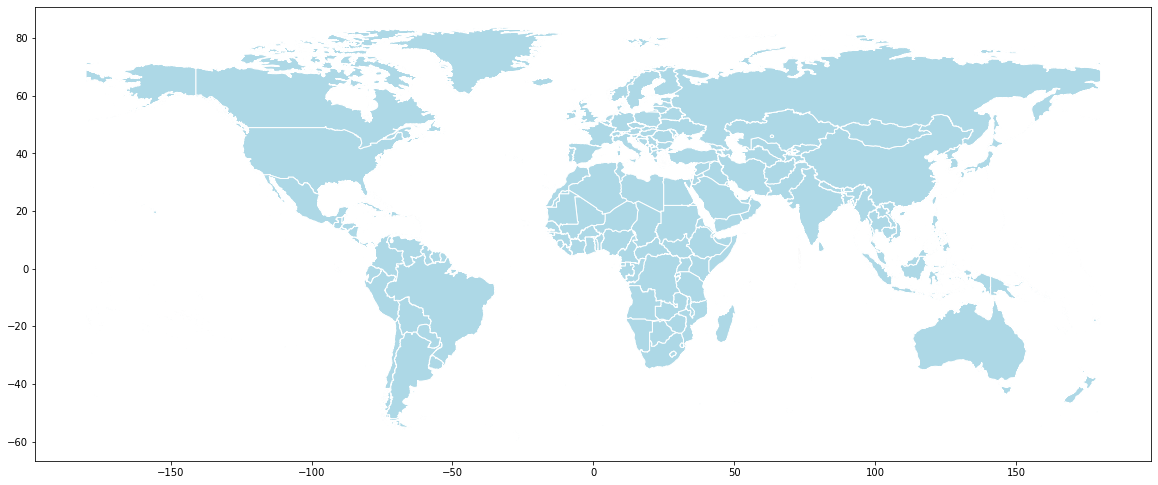

In [19]:
import geopandas as gpd

# Setting the path to the shapefile
shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
CuraÃ§ao not found in regex
SÃ£o TomÃ© and Principe not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex
C:\Users\gianm\AppData\Local\Temp/ipykernel_8380/3888343567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_c

(-197.99999999999991, 198.0, -66.62809417064994, 90.78944326365007)

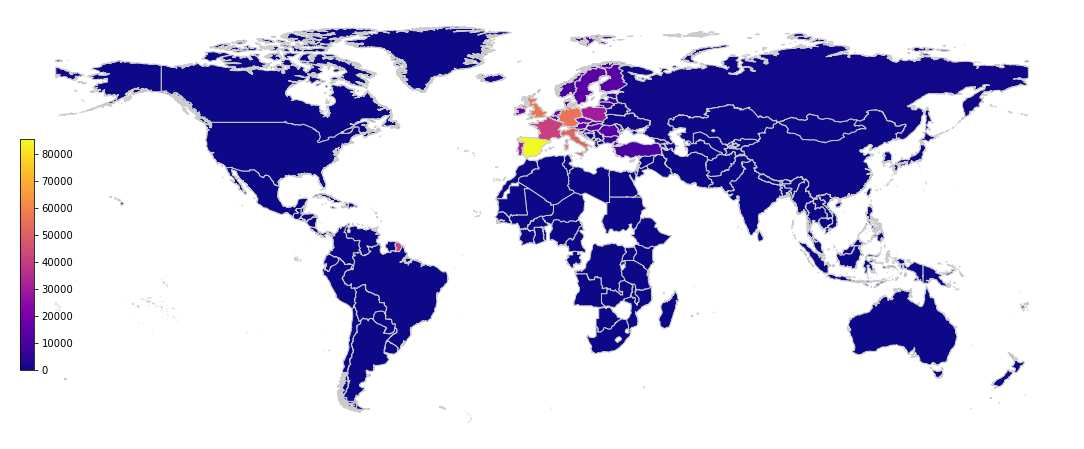

In [20]:
import country_converter as coco

fig, ax = plt.subplots(1, figsize=(20, 8))

# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# geo_df contains iso3 codes so we need to convert them to iso2
geo_df['iso2_code'] = coco.convert(names=list(geo_df['country']), to='ISO2', not_found='NULL')
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)
merged_df.plot(column='in degree', ax=ax, edgecolor='0.8', linewidth=1, cmap='plasma')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=merged_df['in degree'].min(), 
                                              vmax=merged_df['in degree'].max()), cmap='plasma')

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.axis('off')

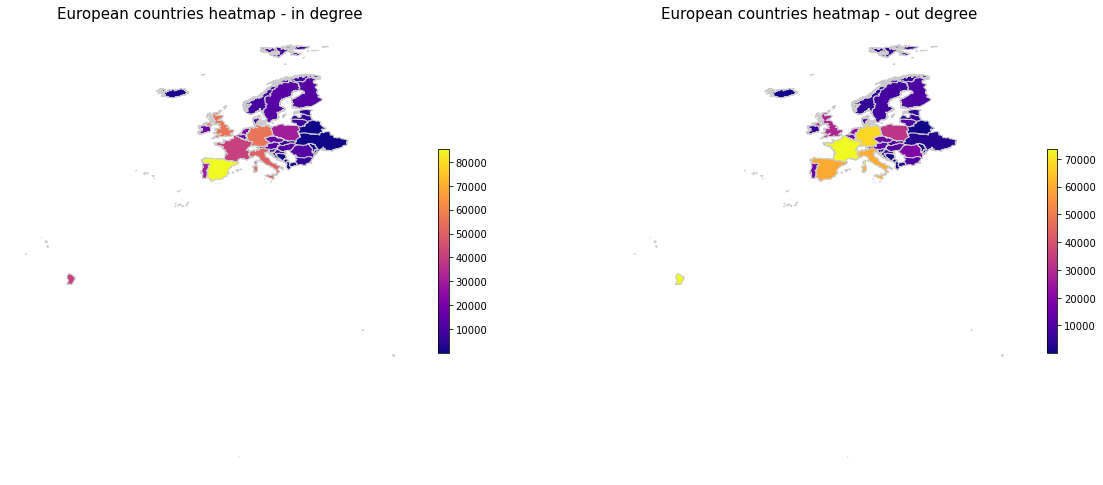

In [21]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'North Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'San Marino', 'Holy See']

# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

deg_list = ['in degree', 'out degree']
fig4, ax4 = plt.subplots(1, 2, figsize=(20,15))


for i in range(len(deg_list)):
    european_df.plot(column=deg_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='plasma')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[deg_list[i]].min(), 
                                              vmax=european_df[deg_list[i]].max()), cmap='plasma')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + deg_list[i], fontsize=15)